In [21]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

In [22]:
class DecisionNode:
    
    def __init__(self, condition=None, true_branch=None, false_branch=None, value=None, name="Node"):
        self.condition = condition
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.value = value
        self.name = name 

    def is_leaf(self):
        return self.value is not None

In [ ]:
class RestaurantSentimentAnalyzer:

    def __init__(self):
        self.positive_keywords = [
            'enak', 'sesuai', 'lezat', 'nikmat', 'sedap', 'mantap', 'bagus', 'baik',
            'fresh', 'segar', 'bersih', 'ramah', 'murah', 'recommended',
            'cocok', 'puas', 'suka', 'love', 'amazing', 'delicious',
            'oke', 'ok', 'nyaman', 'cepat', 'favorit', 'juara', 'istimewa', 'top',
            'hemat', 'lengkap', 'memuaskan', 'menarik', 'rapi', 'seru', 'sukses', 'tenang', 'terbaik', 'terjangkau'
        ]

        self.negative_keywords = [
            'jelek', 'buruk', 'mahal', 'kotor', 'lama',
            'lambat', 'dingin', 'panas', 'asin', 'hambar', 'basi',
            'kecewa', 'bad', 'terrible', 'kurang', 'payah', 'mengecewakan',
            'bau', 'jijik', 'sumpek', 'sempit', 'berisik', 'tumpang', 'kaku',
            'cacat', 'berat', 'bocor', 'rusak', 'susah', 'tipis'
        ]
        
        # Initialize decision tree components
        self.decision_tree = None
        self.vectorizer = None
        self.feature_names = []

    def _build_conceptual_decision_tree_branches(self):
        # Kondisi bantu untuk node
        def _has_positive_keywords_cond(data_tuple):
            text, _, _ = data_tuple
            return any(word in text for word in self.positive_keywords)

        def _has_negative_keywords_cond(data_tuple):
            text, _, _ = data_tuple
            return any(word in text for word in self.negative_keywords)

        def _has_negation_cond(data_tuple):
            _, negated_words, _ = data_tuple
            return len(negated_words) > 0

        # --- Node Level 3 (Hasil Akhir atau mendekati akhir) ---
        # A1: Positif tanpa 'tidak'
        a1_neutral = DecisionNode(value='neutral', name='RESULT_NEU_A1')
        a1_positive = DecisionNode(value='positive', name='RESULT_POS')
        a1_branch = DecisionNode(
            condition=lambda data_tuple: self._has_independent_negative(data_tuple[0], data_tuple[1]),
            true_branch=a1_neutral, # 'Ada Negatif Lain'
            false_branch=a1_positive, # 'Tidak ada Negatif Lain'
            name='L2_POS_NO_NEG'
        )
        input

        # A2: Positif dengan 'tidak' (efektif negatif)
        a2_neutral = DecisionNode(value='neutral', name='RESULT_NEU_A2')
        a2_negative = DecisionNode(value='negative', name='RESULT_NEG')
        a2_branch = DecisionNode(
            condition=lambda data_tuple: self._has_independent_positive(data_tuple[0], data_tuple[1]),
            true_branch=a2_neutral, # 'Ada Positif Lain'
            false_branch=a2_negative, # 'Tidak ada Positif Lain'
            name='L2_POS_WITH_NEG'
        )

        # B1: Negatif tanpa 'tidak'
        b1_neutral = DecisionNode(value='neutral', name='RESULT_NEU_B1')
        b1_negative = DecisionNode(value='negative', name='RESULT_NEG')
        b1_branch = DecisionNode(
            condition=lambda data_tuple: self._has_independent_positive(data_tuple[0], data_tuple[1]),
            true_branch=b1_neutral, # 'Ada Positif Lain'
            false_branch=b1_negative, # 'Tidak ada Positif Lain'
            name='L2_NEG_NO_NEG'
        )

        # B2: Negatif dengan 'tidak' (efektif positif)
        b2_neutral = DecisionNode(value='neutral', name='RESULT_NEU_B2')
        b2_positive = DecisionNode(value='positive', name='RESULT_POS')
        b2_branch = DecisionNode(
            condition=lambda data_tuple: self._has_independent_negative(data_tuple[0], data_tuple[1]),
            true_branch=b2_neutral, # 'Ada Negatif Lain'
            false_branch=b2_positive, # 'Tidak ada Negatif Lain'
            name='L2_NEG_WITH_NEG'
        )

        # --- Node Level 2 (Pengecekan Negasi 'tidak') ---
        positive_path_node = DecisionNode(
            condition=_has_negation_cond,
            true_branch=a2_branch,  # 'Dengan 'tidak'' (mengarah ke A2)
            false_branch=a1_branch, # 'Tanpa 'tidak'' (mengarah ke A1)
            name='L1_POS'
        )

        negative_path_node = DecisionNode(
            condition=_has_negation_cond,
            true_branch=b2_branch, # 'Dengan 'tidak'' (mengarah ke B2)
            false_branch=b1_branch, # 'Tanpa 'tidak'' (mengarah ke B1)
            name='L1_NEG'
        )
        return {
            'positive_path_node': positive_path_node,
            'negative_path_node': negative_path_node,
            'has_positive_keywords_cond': _has_positive_keywords_cond,
            'has_negative_keywords_cond': _has_negative_keywords_cond
        }

    def _prepare_decision_tree_features(self, texts):
        """Prepare features for decision tree training"""
        features = []
        labels = []
        
        for text in texts:
            # Extract features for each text
            cleaned_text = self.preprocess_text(text)
            negated_words = self._find_negated_words(cleaned_text)
            
            # Feature extraction
            has_positive = any(word in cleaned_text for word in self.positive_keywords)
            has_negative = any(word in cleaned_text for word in self.negative_keywords)
            has_negation = len(negated_words) > 0
            has_independent_positive = self._has_independent_positive(cleaned_text, negated_words)
            has_independent_negative = self._has_independent_negative(cleaned_text, negated_words)
            
            # Count features
            pos_count = sum(1 for word in self.positive_keywords if word in cleaned_text)
            neg_count = sum(1 for word in self.negative_keywords if word in cleaned_text)
            negation_count = len(negated_words)
            
            feature_vector = [
                int(has_positive),
                int(has_negative), 
                int(has_negation),
                int(has_independent_positive),
                int(has_independent_negative),
                pos_count,
                neg_count,
                negation_count
            ]
            
            features.append(feature_vector)
            
            # Generate label using existing rule-based logic
            sentiment, _ = self.analyze_sentiment_rules(text)
            labels.append(sentiment)
            
        return np.array(features), np.array(labels)

    def _train_decision_tree(self, texts):
        X, y = self._prepare_decision_tree_features(texts)
        
        # Feature names for interpretability
        self.feature_names = [
            'has_positive', 'has_negative', 'has_negation',
            'has_independent_positive', 'has_independent_negative',
            'pos_count', 'neg_count', 'negation_count'
        ]
        
        # Train decision tree
        self.decision_tree = DecisionTreeClassifier(
            random_state=42,
            max_depth=10,
            min_samples_split=2,
            min_samples_leaf=1
        )
        
        self.decision_tree.fit(X, y)
        return self.decision_tree

    def _predict_with_decision_tree(self, text):
        """Predict sentiment using trained decision tree"""
        if self.decision_tree is None:
            return self.analyze_sentiment_rules(text)
            
        cleaned_text = self.preprocess_text(text)
        negated_words = self._find_negated_words(cleaned_text)
        
        # Extract same features as training
        has_positive = any(word in cleaned_text for word in self.positive_keywords)
        has_negative = any(word in cleaned_text for word in self.negative_keywords)
        has_negation = len(negated_words) > 0
        has_independent_positive = self._has_independent_positive(cleaned_text, negated_words)
        has_independent_negative = self._has_independent_negative(cleaned_text, negated_words)
        
        pos_count = sum(1 for word in self.positive_keywords if word in cleaned_text)
        neg_count = sum(1 for word in self.negative_keywords if word in cleaned_text)
        negation_count = len(negated_words)
        
        feature_vector = np.array([[
            int(has_positive),
            int(has_negative), 
            int(has_negation),
            int(has_independent_positive),
            int(has_independent_negative),
            pos_count,
            neg_count,
            negation_count
        ]])
        
        # Get prediction and decision path
        prediction = self.decision_tree.predict(feature_vector)[0]
        
        # Trace decision path to maintain same output format
        path_taken = self._trace_decision_tree_path(feature_vector[0], text)
        
        return prediction, path_taken

    def _trace_decision_tree_path(self, feature_vector, original_text):
        """Trace decision tree path to maintain same path format as original"""
        path_taken = []
        cleaned_text = self.preprocess_text(original_text)
        negated_words = self._find_negated_words(cleaned_text)
        
        path_taken.append({'node': 'START', 'label': 'Teks Masuk'})
        
        # Simulate original logic path for consistency
        data_for_tree = (cleaned_text, negated_words, cleaned_text)
        
        branches = self._build_conceptual_decision_tree_branches()
        has_pos_keywords = branches['has_positive_keywords_cond'](data_for_tree)
        has_neg_keywords = branches['has_negative_keywords_cond'](data_for_tree)
        
        # Use decision tree prediction but maintain original path structure
        prediction = self.decision_tree.predict(feature_vector.reshape(1, -1))[0]
        
        # Logika utama pohon keputusan (maintaining original path structure)
        if has_pos_keywords and has_neg_keywords:
            path_taken.append({'node': 'L1_CHECK', 'label': 'Ditemukan Positif & Negatif'})
            # Use decision tree result but maintain path format
            label_mixed = f"Decision Tree: {prediction.upper()}"
            if prediction == 'positive':
                path_taken.append({'node': 'RESULT_POS', 'label': label_mixed})
            elif prediction == 'negative':
                path_taken.append({'node': 'RESULT_NEG', 'label': label_mixed})
            else:
                path_taken.append({'node': 'RESULT_NEU_A1', 'label': label_mixed})
        elif has_pos_keywords and not has_neg_keywords:
            path_taken.append({'node': 'L1_POS', 'label': 'Ditemukan Positif'})
            # Simulate traversal for positive path
            sentiment_result = self._traverse_tree_and_record_path(branches['positive_path_node'], data_for_tree, path_taken)
        elif has_neg_keywords and not has_pos_keywords:
            path_taken.append({'node': 'L1_NEG', 'label': 'Ditemukan Negatif'})
            # Simulate traversal for negative path
            sentiment_result = self._traverse_tree_and_record_path(branches['negative_path_node'], data_for_tree, path_taken)
        else:
            path_taken.append({'node': 'L1_NONE', 'label': 'Tidak Ada Kata Kunci'})
            # Add neutral result
            path_taken.append({'node': 'RESULT_NEU_A1', 'label': 'NEUTRAL'})
        
        return path_taken

    def _traverse_tree_and_record_path(self, node, data_tuple, path_trace):
        if node.is_leaf():
            # Jika mencapai node daun, tambahkan ke jalur dan kembalikan sentimen
            path_trace.append({'node': node.name, 'label': node.value.upper()})
            return node.value

        condition_met = node.condition(data_tuple)
        label_for_arrow = "" # Label untuk panah di visualisasi

        # Menentukan label panah berdasarkan jenis node
        if 'pos_no_neg' in node.name.lower():
            label_for_arrow = 'Ada Negatif Lain' if condition_met else 'Tidak ada Negatif Lain'
        elif 'pos_with_neg' in node.name.lower():
            label_for_arrow = 'Ada Positif Lain' if condition_met else 'Tidak ada Positif Lain'
        elif 'neg_no_neg' in node.name.lower():
            label_for_arrow = 'Ada Positif Lain' if condition_met else 'Tidak ada Positif Lain'
        elif 'neg_with_neg' in node.name.lower():
            label_for_arrow = 'Ada Negatif Lain' if condition_met else 'Tidak ada Negatif Lain'
        elif 'l1_pos' in node.name.lower() or 'l1_neg' in node.name.lower():
            label_for_arrow = "Dengan 'tidak'" if condition_met else "Tanpa 'tidak'"
        else:
            label_for_arrow = "True" if condition_met else "False" # Label umum jika tidak cocok

        path_trace.append({'node': node.name, 'label': label_for_arrow})

        if condition_met:
            return self._traverse_tree_and_record_path(node.true_branch, data_tuple, path_trace)
        else:
            return self._traverse_tree_and_record_path(node.false_branch, data_tuple, path_trace)

    def _resolve_mixed_sentiment(self, data_tuple, path_trace):
        text_lower, negated_words, _ = data_tuple
        independent_positive, independent_negative = self._find_independent_sentiment_words(text_lower, negated_words)

        negated_positive_effect = 0 # Misal 'tidak enak' membuat efek negatif
        negated_negative_effect = 0 # Misal 'tidak buruk' membuat efek positif

        for negated_word in negated_words:
            if negated_word in self.positive_keywords:
                negated_positive_effect += 1
            elif negated_word in self.negative_keywords:
                negated_negative_effect += 1

        total_positive_score = len(independent_positive) + negated_negative_effect
        total_negative_score = len(independent_negative) + negated_positive_effect

        sentiment_result = 'neutral'
        if total_positive_score > total_negative_score:
            sentiment_result = 'positive'
        elif total_negative_score > total_positive_score:
            sentiment_result = 'negative'
        else: # Skor sama atau tidak ada efek
            sentiment_result = 'neutral'

        # Rekam hasil dari resolusi sentimen campuran
        label_mixed = f"Skor Pos: {total_positive_score}, Neg: {total_negative_score}"
        if sentiment_result == 'positive':
            path_trace.append({'node': 'RESULT_POS', 'label': label_mixed})
        elif sentiment_result == 'negative':
            path_trace.append({'node': 'RESULT_NEG', 'label': label_mixed})
        else:
            path_trace.append({'node': 'RESULT_NEU_A1', 'label': label_mixed}) # Menggunakan node Netral umum

        return sentiment_result

    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        # Menghapus karakter selain huruf, angka, dan spasi
        text = re.sub(r'[^a-z0-9\s]', '', text)
        # Mengganti beberapa spasi dengan satu spasi dan menghapus spasi di awal/akhir
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def _find_negated_words(self, text):
        pattern = r'\btidak\s+(\w+)'
        matches = re.findall(pattern, text.lower())
        return matches

    def _has_independent_positive(self, text_lower, negated_words):
        return any(word in text_lower and word not in negated_words for word in self.positive_keywords)

    def _has_independent_negative(self, text_lower, negated_words):
        return any(word in text_lower and word not in negated_words for word in self.negative_keywords)

    def _find_independent_sentiment_words(self, text_lower, negated_words):
        independent_positive = [word for word in self.positive_keywords if word in text_lower and word not in negated_words]
        independent_negative = [word for word in self.negative_keywords if word in text_lower and word not in negated_words]
        return independent_positive, independent_negative

    def analyze_sentiment_rules(self, text):
        path_taken = []
        cleaned_text = self.preprocess_text(text)
        negated_words = self._find_negated_words(cleaned_text)

        path_taken.append({'node': 'START', 'label': 'Teks Masuk'})

        # Data tuple untuk kondisi pohon: (teks_bersih, kata_dinegasi, teks_bersih_untuk_referensi)
        data_for_tree = (cleaned_text, negated_words, cleaned_text)

        branches = self._build_conceptual_decision_tree_branches()
        has_pos_keywords = branches['has_positive_keywords_cond'](data_for_tree)
        has_neg_keywords = branches['has_negative_keywords_cond'](data_for_tree)

        sentiment_result = 'neutral' # Sentimen default

        # Logika utama pohon keputusan
        if has_pos_keywords and has_neg_keywords:
            path_taken.append({'node': 'L1_CHECK', 'label': 'Ditemukan Positif & Negatif'})
            sentiment_result = self._resolve_mixed_sentiment(data_for_tree, path_taken)
        elif has_pos_keywords and not has_neg_keywords:
            path_taken.append({'node': 'L1_POS', 'label': 'Ditemukan Positif'})
            sentiment_result = self._traverse_tree_and_record_path(branches['positive_path_node'], data_for_tree, path_taken)
        elif has_neg_keywords and not has_pos_keywords:
            path_taken.append({'node': 'L1_NEG', 'label': 'Ditemukan Negatif'})
            sentiment_result = self._traverse_tree_and_record_path(branches['negative_path_node'], data_for_tree, path_taken)
        else:
            path_taken.append({'node': 'L1_NONE', 'label': 'Tidak Ada Kata Kunci'})
            sentiment_result = 'neutral' # Tidak ada kata kunci sentimen ditemukan

        return sentiment_result, path_taken

    def analyze_sentiment_decision_tree(self, text):
        """Main method using decision tree approach"""
        if self.decision_tree is None:
            # Fallback to rule-based if tree not trained
            return self.analyze_sentiment_rules(text)
        return self._predict_with_decision_tree(text)

    def load_and_prepare_data(self, file_path='Restaurant_Reviews.tsv'):
        try:
            df = pd.read_csv(file_path, sep='\t', encoding='utf-8')
            if df.shape[1] >= 1:
                df.columns = ['review_text'] + [f'col_{i}' for i in range(1, df.shape[1])]
            else:
                return pd.DataFrame(columns=['review_text', 'review_clean'])

        except FileNotFoundError:
            print(f"Error: File '{file_path}' tidak ditemukan. Pastikan file ada di direktori yang sama.")
            return None
        except Exception as e:
            print(f"Error memuat atau mengurai {file_path}: {e}")
            return None

        df['review_clean'] = df['review_text'].apply(self.preprocess_text)
        df = df[df['review_clean'] != ''].reset_index(drop=True)
        
        # Train decision tree on the loaded data
        if len(df) > 0:
            self._train_decision_tree(df['review_text'].tolist())
        
        return df

def visualize_sentiment_path(text, path_taken, sentiment):
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.axis('off')

    colors = {
        'default': '#E8F4FD',         
        'highlight': '#FFD700',      
        'arrow': '#6C757D',           
        'arrow_highlight': '#007bff', 
        'result_pos': '#32CD32',      
        'result_neg': '#FF6347',   
        'result_neu': '#6A5ACD'   
    }

    node_positions = {
        'START': (7, 9),
        'L1_CHECK': (7, 7.5),
        'L1_POS': (3.5, 6),
        'L1_NEG': (10.5, 6),
        'L1_NONE': (7, 6), # Jalur untuk 'tidak ada kata kunci sentimen'
        'L2_POS_NO_NEG': (2, 4.5), # A1 (Positif tapi tanpa negasi)
        'L2_POS_WITH_NEG': (5, 4.5), # A2 (Positif dengan negasi)
        'L2_NEG_NO_NEG': (9, 4.5), # B1 (Negatif tapi tanpa negasi)
        'L2_NEG_WITH_NEG': (12, 4.5), # B2 (Negatif dengan negasi)
        'RESULT_POS': (2, 3), # Hasil akhir Positif
        'RESULT_NEG': (5, 3), # Hasil akhir Negatif
        'RESULT_NEU_A1': (3.5, 3), # Netral dari A1.2 (Pos, tanpa negasi, tapi ada negatif lain)
        'RESULT_NEU_A2': (6.5, 3), # Netral dari A2.2 (Pos, dengan negasi, tapi ada positif lain)
        'RESULT_NEU_B1': (10.5, 3), # Netral dari B1.2 (Neg, tanpa negasi, tapi ada positif lain)
        'RESULT_NEU_B2': (13.5, 3) # Netral dari B2.2 (Neg, dengan negasi, tapi ada negatif lain)
    }

    node_texts = {
        'START': "START\nAnalisis Teks",
        'L1_CHECK': "Deteksi Kata Kunci\nPositif/Negatif",
        'L1_POS': "Ada Positif",
        'L1_NEG': "Ada Negatif",
        'L1_NONE': "Tidak Ada\nKata Kunci",
        'L2_POS_NO_NEG': "A1: Positif\nTANPA 'tidak'",
        'L2_POS_WITH_NEG': "A2: Positif\nDENGAN 'tidak'",
        'L2_NEG_NO_NEG': "B1: Negatif\nTANPA 'tidak'",
        'L2_NEG_WITH_NEG': "B2: Negatif\nDENGAN 'tidak'",
        'RESULT_POS': "POSITIF",
        'RESULT_NEG': "NEGATIF",
        'RESULT_NEU_A1': "NETRAL",
        'RESULT_NEU_A2': "NETRAL",
        'RESULT_NEU_B1': "NETRAL",
        'RESULT_NEU_B2': "NETRAL"
    }

    # Fungsi bantu untuk membuat kotak node
    def _create_path_box(key, is_highlighted, result_sentiment=None):
        x, y = node_positions[key]
        text = node_texts.get(key, key)
        color = colors['default']
        edgecolor = 'gray'
        linewidth = 1

        if is_highlighted:
            color = colors['highlight']
            edgecolor = 'black'
            linewidth = 2
            if key.startswith('RESULT_'): # Jika ini node hasil, gunakan warna sentimen
                if result_sentiment == 'positive':
                    color = colors['result_pos']
                elif result_sentiment == 'negative':
                    color = colors['result_neg']
                elif result_sentiment == 'neutral':
                    color = colors['result_neu']

        fontsize = 9 if key != 'START' else 10
        box = FancyBboxPatch((x - 1.5, y - 0.4), 3, 0.8,
                             boxstyle="round,pad=0.1",
                             facecolor=color, edgecolor=edgecolor, linewidth=linewidth)
        ax.add_patch(box)
        ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, fontweight='bold', wrap=True)

    # Fungsi bantu untuk menggambar panah antar node
    def _draw_path_arrow(start_key, end_key, is_highlighted, label=''):
        x1, y1 = node_positions[start_key]
        x2, y2 = node_positions[end_key]
        arrow_color = colors['arrow_highlight'] if is_highlighted else colors['arrow']
        lw = 2 if is_highlighted else 1.5
        ax.annotate('', xy=(x2, y2 + 0.1), xytext=(x1, y1 - 0.1),
                    arrowprops=dict(arrowstyle='->', color=arrow_color, lw=lw))
        if label:
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            ax.text(mid_x, mid_y + 0.2, label, fontsize=8, color=arrow_color, ha='center')

    # Gambar semua node potensial terlebih dahulu (tidak disorot)
    for key in node_positions:
        _create_path_box(key, False)

    # Sorot jalur yang diambil berdasarkan 'path_taken'
    for i in range(len(path_taken)):
        current_step_info = path_taken[i]
        current_node_key = current_step_info['node']

        # Sorot node saat ini
        _create_path_box(current_node_key, True, sentiment if i == len(path_taken) - 1 else None)

        # Gambar panah dari node sebelumnya ke node saat ini (jika ada)
        if i > 0:
            prev_node_key = path_taken[i-1]['node']
            _draw_path_arrow(prev_node_key, current_node_key, True, current_step_info['label'])
        elif current_node_key == 'START': # Panah awal ke node START
            _draw_path_arrow('START', current_node_key, True, current_step_info['label'])

    # Tambahkan teks ulasan di bagian bawah visualisasi
    ax.text(7, 0.5, f"Review: \"{text}\"\nSentimen: {sentiment.upper()}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=1))

    # Judul visualisasi
    plt.title(f"Alur Analisis Sentimen untuk Review\n\"{text[:50]}{'...' if len(text) > 50 else ''}\"",
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# ===== MAIN PROGRAM =====

# Inisialisasi analyzer
analyzer = RestaurantSentimentAnalyzer()
file_path = 'Restaurant_Reviews.tsv'
df_reviews = analyzer.load_and_prepare_data(file_path)


--- Ulasan No. 6 ---
Teks: "Suka banget dengan masakan di sini, fresh dan enak."
Sentimen Terprediksi: POSITIVE


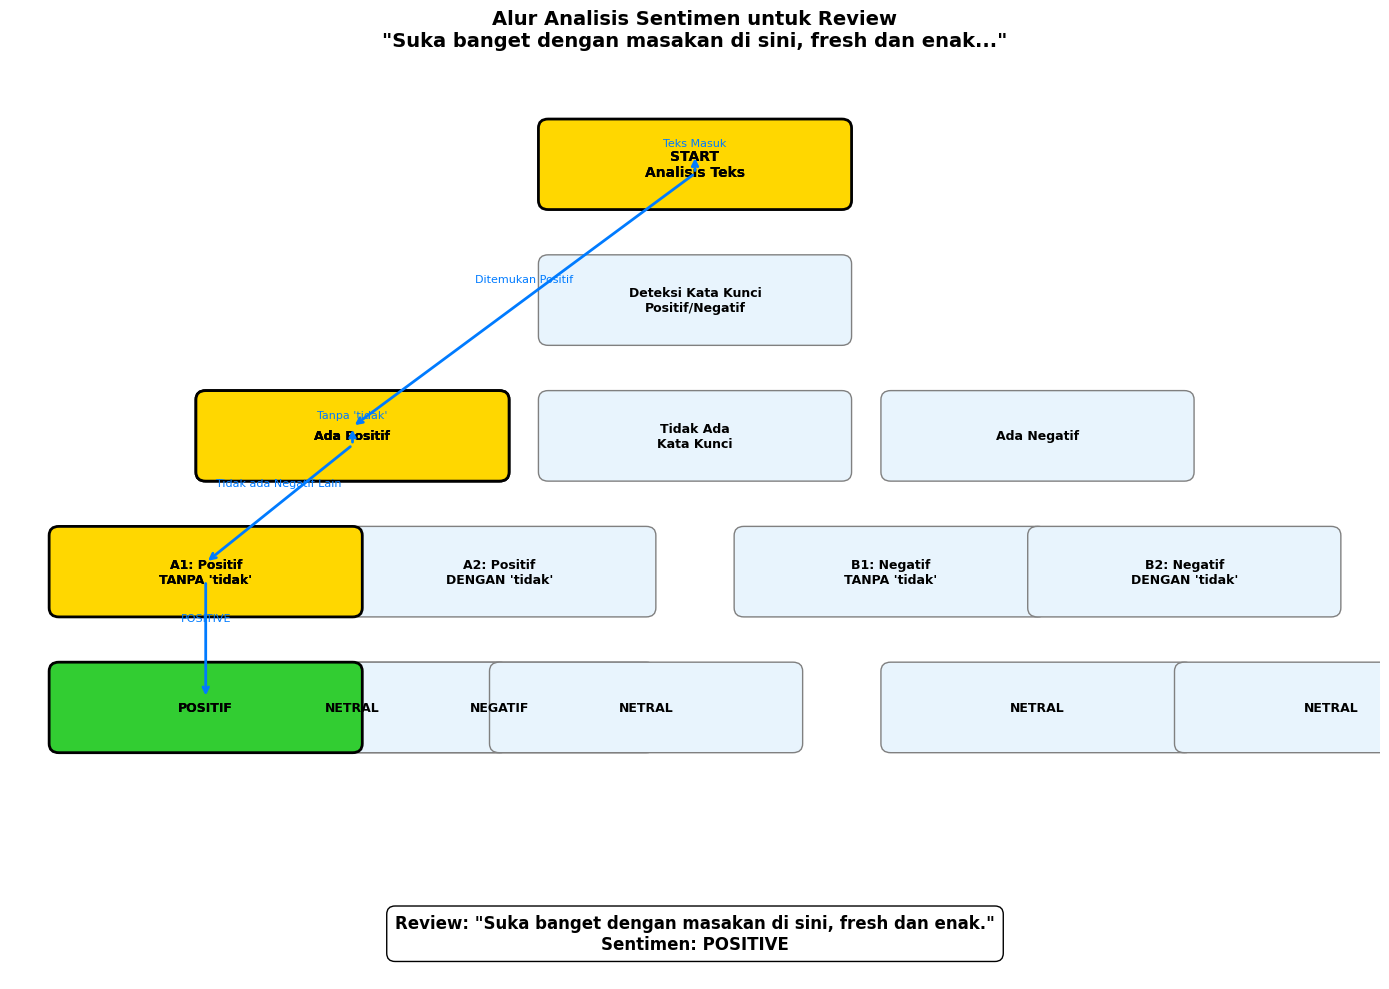


--- Hasil Analisis Komentar Manual ---
Teks: "jijiik"
Sentimen Terprediksi: NEUTRAL


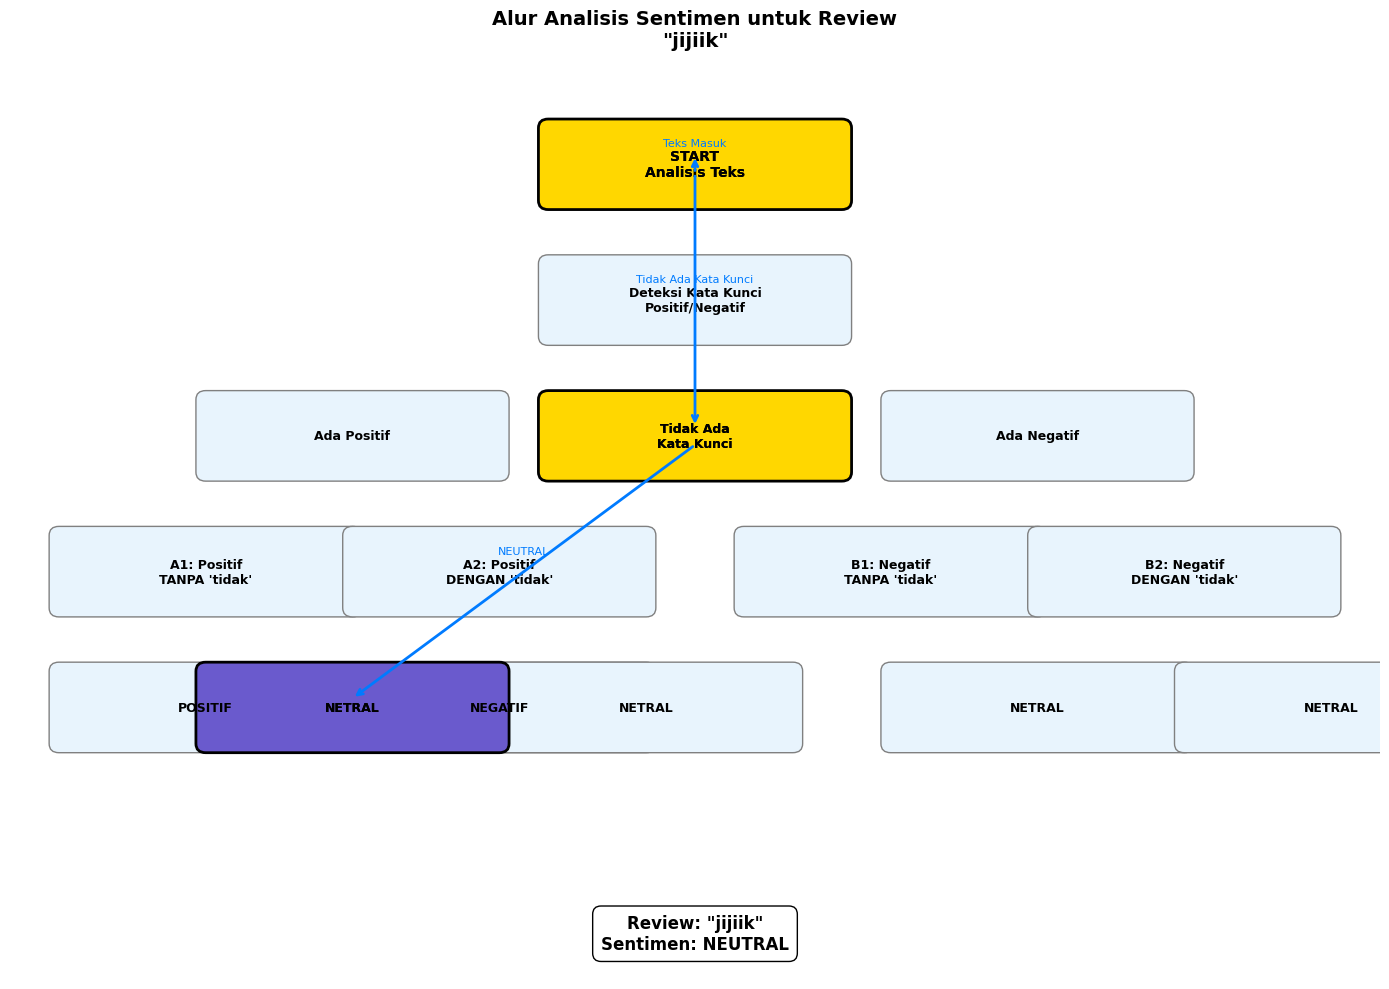

In [ ]:
if df_reviews is not None:
    try:
        user_input = input(f"Masukkan nomor ulasan yang ingin divisualisasikan (1-{len(df_reviews)}): ")
        review_index = int(user_input) - 1
        
        if 0 <= review_index < len(df_reviews):
            selected_review_text_clean = df_reviews.loc[review_index, 'review_clean']
            original_review_text = df_reviews.loc[review_index, 'review_text']
            
            # Gunakan decision tree jika sudah dilatih, fallback ke rules
            if analyzer.decision_tree is not None:
                sentiment, path = analyzer.analyze_sentiment_decision_tree(selected_review_text_clean)
            else:
                sentiment, path = analyzer.analyze_sentiment_rules(selected_review_text_clean)
            
            print(f"\n--- Ulasan No. {review_index + 1} ---")
            print(f"Teks: \"{original_review_text}\"")
            print(f"Sentimen Terprediksi: {sentiment.upper()}")
            
            visualize_sentiment_path(original_review_text, path, sentiment)
        
        else:
            print(f"Nomor ulasan tidak valid. Masukkan angka antara 1 dan {len(df_reviews)}.")
    
    except ValueError:
        print("Input tidak valid. Harap masukkan angka.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# Analisis input manual dari user



--- Hasil Analisis Komentar Manual ---
Teks: "buruk"
Sentimen Terprediksi: NEGATIVE


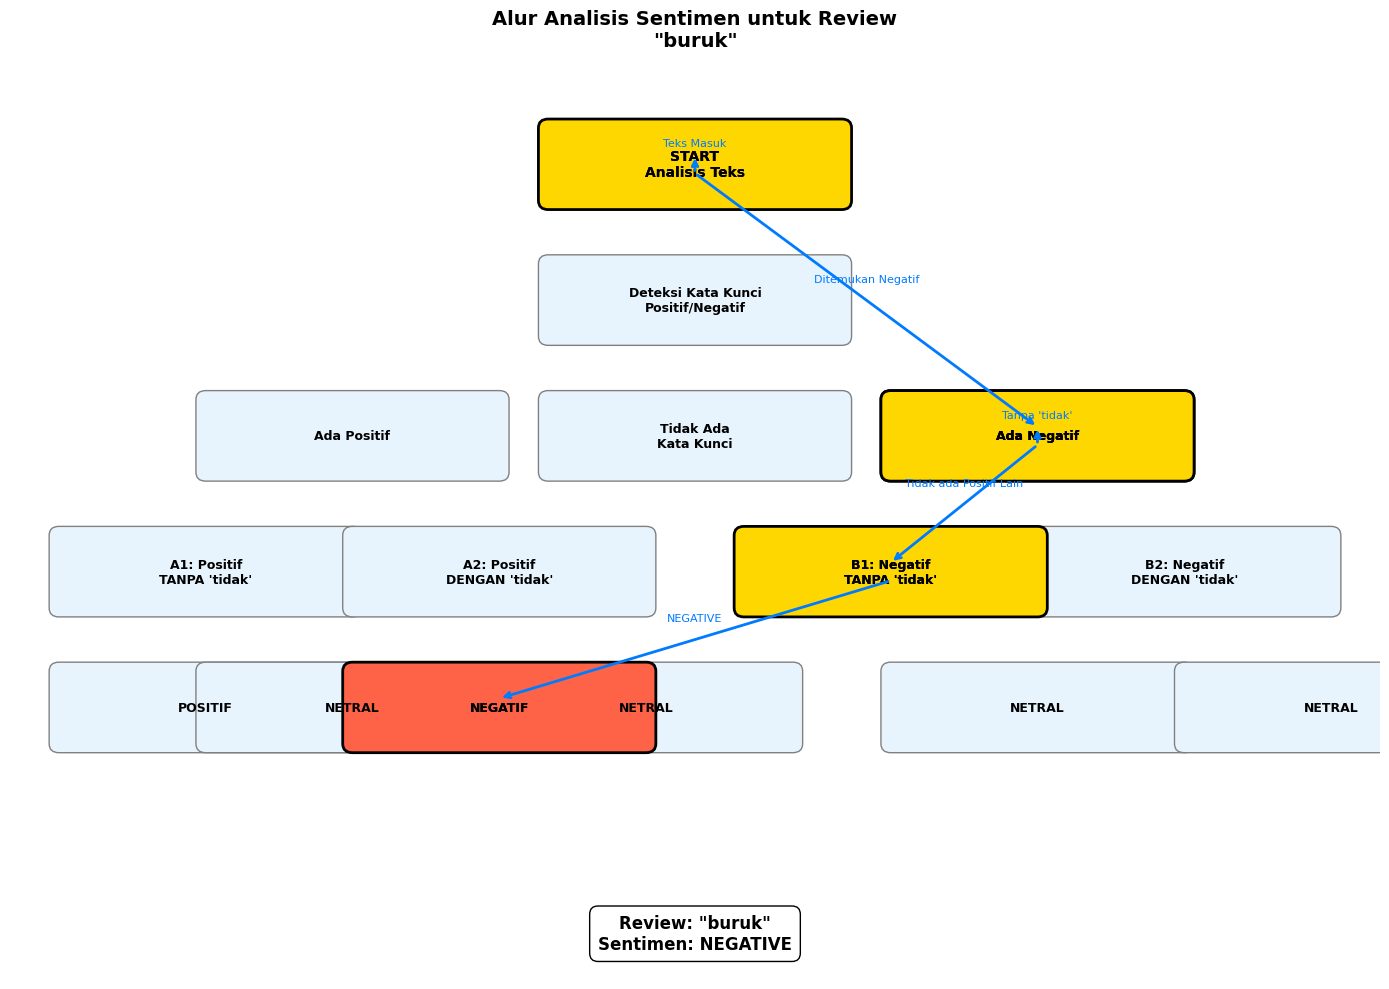

In [25]:
try:
    user_input_text = input("Masukkan komentar restoran yang ingin Anda analisis: ")
    
    # Preprocessing seperti biasa
    user_input_clean = re.sub('[^a-zA-Z]', ' ', user_input_text)
    user_input_clean = user_input_clean.lower()
    user_input_clean = user_input_clean.split()
    user_input_clean = ' '.join(user_input_clean)
    
    # Analisis sentimen - gunakan decision tree jika tersedia
    if analyzer.decision_tree is not None:
        sentiment, path = analyzer.analyze_sentiment_decision_tree(user_input_clean)
    else:
        sentiment, path = analyzer.analyze_sentiment_rules(user_input_clean)
    
    print("\n--- Hasil Analisis Komentar Manual ---")
    print(f"Teks: \"{user_input_text}\"")
    print(f"Sentimen Terprediksi: {sentiment.upper()}")
    
    # Visualisasi jalur analisis sentimen
    visualize_sentiment_path(user_input_text, path, sentiment)

except Exception as e:
    print(f"Terjadi kesalahan saat memproses komentar: {e}")